In [11]:
!pip install tensorflow-gpu==2.4.1

In [12]:
#!pip uninstall h5py
#!pip3 install numpy --upgrade --ignore-installed


In [1]:
import tensorflow as tf
from six.moves import builtins

tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
#pip install opencv-python

### Score CAM 

In [4]:
import cv2
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsample to original input size
    #INTER_LINEAR : a bilinear interpolation (used by default)
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def read_and_preprocess_img(path, size=(224,224)):
    img = load_img(path, target_size=size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
def superimpose(original_img_path, cam, emphasize=False):
    
    img_bgr = cv2.imread(original_img_path)

    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, 0.5, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    #fin = cv2.addWeighted(heatmap_img, 0.7, img, 0.3, 0)
    
    return superimposed_img_rgb
def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

In [5]:
from numpy.ma.core import shape
import PIL

tf.config.run_functions_eagerly(True)

def get_index_and_xmin_ymin_xmax_ymax(df_all_data,x):
      index=0
      #mean_image=np.mean(x)

      for i in range(len(df_all_data['Mean value of the image'])):
        mean_chaque_image=(np.array(df_all_data['Mean value of the image'][i]))
        if (mean_chaque_image==x):
          print(i)
          index=i
      xmin=df_all_data.loc[index][3]
      ymin=df_all_data.loc[index][4]
      xmax=df_all_data.loc[index][5]
      ymax=df_all_data.loc[index][6]

      return index,xmin,ymin,xmax,ymax

def custom_loss(input):
    index=0
    mean_image=0
    
    mean = K.mean(input, axis=-1)

    if len(input.shape) == 3:
      mean_image = K.permute_dimensions(K.repeat(mean, input.shape.as_list()[-1]), [0,2,1])

    elif len(input.shape) == 2:
      mean_image = K.reshape(K.repeat_elements(mean, input.shape.as_list()[-1], 0),(-1, input.shape.as_list()[-1]))
    
    model = VGG16(include_top=True, weights='imagenet')
    layer_name = 'block5_conv3'
    #np.mean(np.array(input))))

    index,xmin,ymin,xmax,ymax=get_index_and_xmin_ymin_xmax_ymax(df_all_data,mean_image)
    score_cam = ScoreCam(model, img_array, layer_name)

    im = np.array(score_cam)
    im = im[xmin:xmax+1,ymin:ymax+1]
    im = im.flatten()
    perc = np.percentile(im,75)
    loss = tf.keras.losses.CategoricalCrossentropy() + mean_image
    return loss #(1-perc) #+ loss(y_true,y_pred)  #perc_true - perc_pred

def CustomLoss(y_true, y_pred, input):
  
    index=0
    mean_image=0
    
    mean = K.mean(input, axis=-1)

    if len(input.shape) == 3:
      mean_image = K.permute_dimensions(K.repeat(mean, input.shape.as_list()[-1]), [0,2,1])

    elif len(input.shape) == 2:
      mean_image = K.reshape(K.repeat_elements(mean, input.shape.as_list()[-1], 0),(-1, input.shape.as_list()[-1]))

    model = VGG16(include_top=True, weights='imagenet')
    layer_name = 'block5_conv3'
    #loop for a directory containing at least 1000 images from each class of the imagenet dataset

    index,xmin,ymin,xmax,ymax= get_index_and_xmin_ymin_xmax_ymax(df_all_data,x)
    print(index)
    
    filename=df_all_data.loc[index][1]
    #print(filename)
    splitted_filename = filename.split("_", 1)
    classe=splitted_filename[0]
    #print(classe)
    img_path = "/content/drive/MyDrive/BRAFITEC/EN COURS/PROJET LONG/DATASET/"+classe+"/"+filename+".JPEG"

    orig_img=cv2.imread(img_path)
    img_array = read_and_preprocess_img(img_path, size=(224,224))

    score_cam =ScoreCam(model, img_array, layer_name)

    im = np.array(score_cam)
    im = im[xmin:xmax+1,ymin:ymax+1]
    im = im.flatten()
    perc = np.percentile(im,75)
    
    return K.binary_crossentropy(y_true, y_pred) + mean_image #K.mean(input_tensor)

##### function to resize the output image (Activation map) so it matches the size of the original image

In [6]:
def resize(original_img_path, cam, emphasize=False):
    
    img_bgr = cv2.imread(original_img_path)

    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    
    return heatmap

##### produce scorecam activation maps for images of a single class

In [7]:
import os
img_basenames = []

CLASSES=['n04023962','n12144580']
data=[]
IMG_SIZE=224

for classe in CLASSES:
    path = 'H:/ImageNet object localization patched 2019/ILSVRC/Data/CLS-LOC/train/'+classe

    #Use the local GPU - RTX 2080TI #
    with tf.device('/device:GPU:0'):
        for file in os.listdir(path):
            f_name, f_ext = os.path.splitext(file)
            #image=cv2.imread(path+"/"+f_name+".png")
            if file.endswith(".JPEG"):
                #print(file)
                img_basenames.append(f_name)
print(img_basenames)


#import os
#img_basenames = []
#for file in os.listdir("H:/2019 Nicolas Gourgue malaria/BDD malaira/dataset/CAT01/G/BF/9994A323898"): #source images to generate the images with features maps
#for file in os.listdir("H:/2019 Nicolas Gourgue malaria/BDD malaira/dataset/CAT01/G/BF/9994A323898"): #source images to generate the images with features maps
#    if file.endswith(".png"):
        #print(file)
#        img_basenames.append(file)

['n04023962_215', 'n04023962_17151', 'n04023962_3416', 'n04023962_11105', 'n04023962_15613', 'n04023962_38255', 'n04023962_4414', 'n04023962_8015', 'n04023962_8284', 'n04023962_4579', 'n04023962_18048', 'n04023962_27784', 'n04023962_16657', 'n04023962_27087', 'n04023962_41221', 'n04023962_12133', 'n04023962_10748', 'n04023962_12994', 'n04023962_12108', 'n04023962_25664', 'n04023962_13495', 'n04023962_8926', 'n04023962_26793', 'n04023962_6800', 'n04023962_16731', 'n04023962_13979', 'n04023962_11675', 'n04023962_19678', 'n04023962_12496', 'n04023962_9073', 'n04023962_2929', 'n04023962_23612', 'n04023962_15601', 'n04023962_22879', 'n04023962_15644', 'n04023962_50478', 'n04023962_14399', 'n04023962_6467', 'n04023962_46699', 'n04023962_629', 'n04023962_47624', 'n04023962_8440', 'n04023962_6386', 'n04023962_16165', 'n04023962_18704', 'n04023962_25028', 'n04023962_47859', 'n04023962_267', 'n04023962_966', 'n04023962_7629', 'n04023962_27621', 'n04023962_13844', 'n04023962_24908', 'n04023962_87

##### test for one class, make sure you create the output folder for the produced activation maps (heatmaps)

D:\Users\wfogosdarocha\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


KeyboardInterrupt: 

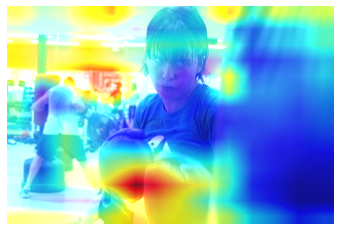

In [10]:
import tensorflow
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import os
#os.chdir("R:/Bureau")
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

#from gradcamutils import GradCam, GradCamPlusPlus, ScoreCam, build_guided_model, GuidedBackPropagation, superimpose, read_and_preprocess_img

model = VGG16(include_top=True, weights='imagenet')
layer_name = 'block5_conv3'
#loop for a directory containing at least 1000 images from each class of the imagenet dataset

for classe in CLASSES:
    path = 'H:/ImageNet object localization patched 2019/ILSVRC/Data/CLS-LOC/train/'+classe
    # choices to add dependending on which dataset
    for basename in img_basenames:
        img_path = path+'/'+basename+'.JPEG'
        #orig_img = np.array(load_img(img_path),dtype=np.uint8)
        orig_img=cv2.imread(img_path)
        img_array = read_and_preprocess_img(img_path, size=(224,224))


        #image_array = np.array(tf.image.resize(image, [224,224]).numpy())
        predictions = model.predict(img_array)
        top = decode_predictions(predictions, top=5)[0]
        

        #Use the local GPU - RTX 2080TI #
        with tf.device('/device:GPU:0'):
            score_cam=ScoreCam(model,img_array,layer_name)
            score_cam_superimposed = superimpose(img_path, score_cam) #Image with feature map

        plt.imshow(orig_img)
        #plt.show()
        plt.axis('off')
        #plt.savefig("D:/Users/wfogosdarocha/Documents/2 CLASSES/"+classe+"/Originals images/"+basename+'.JPEG')
        #plt.savefig(f"D:\Users\wfogosdarocha\Documents\CAM - Malaria`s images\Avec feature map\Healthy\result_{top[0][1]}_{basename}")

        #Seulement feature map 
        plt.imshow(score_cam)
        #plt.show()
        plt.axis('off')
        plt.savefig("D:/Users/wfogosdarocha/Documents/2 CLASSES/"+classe+"/ScoreCam images - Feature maps/"+"result_{}_{}".format(top[0][1],basename))
        #plt.savefig(f"D:\Users\wfogosdarocha\Documents\CAM - Malaria`s images\Avec feature map\Healthy\result_{top[0][1]}_{basename}")

        #superimposed cam is scaled from 0 to 255
        plt.imshow(score_cam_superimposed)
        #plt.show()
        plt.axis('off')
        plt.savefig("D:/Users/wfogosdarocha/Documents/2 CLASSES/"+classe+"/ScoreCam images - Orifginal image with feature maps/"+"result_{}_{}".format(top[0][1],basename))
        #plt.savefig(f"D:\Users\wfogosdarocha\Documents\CAM - Malaria`s images\Avec feature map\Healthy\result_{top[0][1]}_{basename}")



In [ ]:
score_cam,score_cam_superimposed

#### Get XML file annotations containing the ground truth coordinates

In [8]:
import xml.etree.ElementTree as ET


def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text) #bottom
        xmin = int(boxes.find("bndbox/xmin").text) #left
        ymax = int(boxes.find("bndbox/ymax").text) #top
        xmax = int(boxes.find("bndbox/xmax").text) #right

        list_with_single_boxes = [xmin, ymin, xmax, ymax] #[left,bottom,right,top]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes



To create the csv file with all the informations (xmin, ymin, xmax, ymax)

In [21]:
!pip install pandas

Testing for two classes

In [48]:
import cv2
import pandas as pd

CLASSES=['n04023962','n12144580']
data=[]
IMG_SIZE=224

for classe in CLASSES:
    path = 'H:/ImageNet object localization patched 2019/ILSVRC/Annotations/CLS-LOC/train/'+classe

    #Use the local GPU - RTX 2080TI #
    with tf.device('/device:GPU:0'):
        for filename in os.listdir(path):
            name, boxes = read_content(path+"/"+filename)
            f_name, f_ext = os.path.splitext(filename)
            image=cv2.imread("H:/ImageNet object localization patched 2019/ILSVRC/Data/CLS-LOC/train/"+classe+"/"+f_name+".JPEG")

            image_array = np.array(tf.image.resize(image, [224,224]).numpy())
            #df['img'] = [image] # Wrap image in python list

            # Add another row using the "dictionary way"
            d2 = {'filename': f_name, 'Mean value of the image': [np.around(np.mean(image_array),2)]}
            df = pd.DataFrame(data=d2)
            data.append(d2)
            df2 = df.append(data, True)
df2.to_csv(r'D:/Users/wfogosdarocha/Documents/df2_classes_{}_{}_resolution_{}x{}.csv'.format('n04023962','n12144580',IMG_SIZE,IMG_SIZE))
df2

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/286442533.py:25

,filename,Mean value of the image
0,n12144580_18401,80.610001
1,n04023962_21358,[118.73]
2,n04023962_8659,[83.55]
3,n04023962_22196,[26.19]
4,n04023962_10130,[92.4]
...,...,...
1064,n12144580_1470,[130.55]
1065,n12144580_11204,[145.76]
1066,n12144580_9821,[50.36]
1067,n12144580_4877,[117.52]


In [49]:
#a = np.array(df2['Image']).reshape(np.array(df2['Image']).shape[:2])  # You can also use np.reshape()
#print(a.shape)

In [19]:
#Use the local GPU - RTX 2080TI #
with tf.device('/device:GPU:0'):
    for filename in os.listdir(path):
        name, boxes = read_content(path+"/"+filename)
        f_name, f_ext = os.path.splitext(filename)
        image=np.array(cv2.imread("H:/ImageNet object localization patched 2019/ILSVRC/Data/CLS-LOC/train/"+classe+"/"+f_name+".JPEG"))
        #image_array = np.array(tf.image.resize(image, [224,224]).numpy())
        image_array=image_array.flatten()
        if (len(image_array)!=(224*224)):
            break
        #image_array=cv2.resize(image, (224, 224))
        #image_array=np.expand_dims(image_array, axis=0)
        #image_array=image_array.flatten()#.tolist()
        #image_array=np.reshape(image_array, 150528)
        print(image_array)
        pritn("here")

In [20]:
image_array.shape

(150528,)

##### get the bounding box coordinates of each image of a single class and put them in a csv file, to then use for the metrics calculations later on

In [26]:
pip install Pillow

In [50]:
import xml.etree.ElementTree as ET
import os
import cv2
from PIL import Image
import pandas as pd


CLASSES=['n04023962','n12144580']
data=[]

for classe in CLASSES:
    path = 'H:/ImageNet object localization patched 2019/ILSVRC/Annotations/CLS-LOC/train/'+classe
    #Use the local GPU - RTX 2080TI #
    with tf.device('/device:GPU:0'):
        for filename in os.listdir(path):
            name, boxes = read_content(path+"/"+filename)
            f_name, f_ext = os.path.splitext(filename)
            left = boxes[0][0]
            bottom = boxes[0][1]
            right = boxes[0][2]
            top = boxes[0][3]
            #x_data = np.array( [np.array(cv2.imread(path[i])) for i in range(len(path))] )
            ##image=cv2.imread(path+"/"+f_name+".JPEG")
            ##image_array = tf.image.resize(image, [224,224])
            #image_array = image_array.flatten().reshape(224, 224)
            #df['Image'] = [image_array] 
            d = {'filename': f_name, 'Class': classe,  'bbox': boxes, 'xmin':left,'ymin':bottom,'xmax':right,'ymax':top}
            df = pd.DataFrame(data=d)
            data.append(d)
            df3 = df.append(data, True)

df3.to_csv(r'D:/Users/wfogosdarocha/Documents/df3_classes_{}_{}_resolution_{}x{}.csv'.format('n04023962','n12144580',IMG_SIZE,IMG_SIZE))
df3

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df.append(data, True)
D:\Users\WFOGOS~1\AppData\Local\Temp/ipykernel_68024/1062761301.

,filename,Class,bbox,xmin,ymin,xmax,ymax
0,n12144580_18401,n12144580,"[139, 155, 349, 259]",139,155,349,259
1,n12144580_18401,n12144580,"[291, 121, 487, 201]",139,155,349,259
2,n12144580_18401,n12144580,"[188, 146, 405, 245]",139,155,349,259
3,n04023962_21358,n04023962,"[[142, 45, 215, 316]]",142,45,215,316
4,n04023962_8659,n04023962,"[[159, 40, 220, 166]]",159,40,220,166
...,...,...,...,...,...,...,...
1066,n12144580_1470,n12144580,"[[138, 0, 497, 121]]",138,0,497,121
1067,n12144580_11204,n12144580,"[[148, 131, 332, 331]]",148,131,332,331
1068,n12144580_9821,n12144580,"[[312, 149, 356, 222], [179, 164, 240, 242], [...",312,149,356,222
1069,n12144580_4877,n12144580,"[[32, 192, 83, 220]]",32,192,83,220


In [54]:
df_all_data = pd.merge(df2.set_index('filename', drop=True),df3.set_index('filename', drop=True), how='left', left_index=True, right_index=True).dropna().reset_index()
df_all_data.drop_duplicates(subset ="filename",keep = False, inplace = True)
df_all_data.to_csv("ALL_DATA_ALL_CLASSES_resolution_{}X{}.csv".format(IMG_SIZE,IMG_SIZE))
df_all_data

,filename,Mean value of the image,Class,bbox,xmin,ymin,xmax,ymax
0,n04023962_10027,[107.16],n04023962,"[[299, 0, 467, 265]]",299,0,467,265
1,n04023962_10030,[104.25],n04023962,"[[67, 53, 286, 403]]",67,53,286,403
2,n04023962_10108,[108.4],n04023962,"[[220, 0, 335, 498]]",220,0,335,498
3,n04023962_10130,[92.4],n04023962,"[[49, 72, 198, 374]]",49,72,198,374
4,n04023962_10140,[98.81],n04023962,"[[87, 58, 272, 498]]",87,58,272,498
...,...,...,...,...,...,...,...,...
1070,n12144580_9553,[103.22],n12144580,"[[142, 135, 327, 195]]",142,135,327,195
1071,n12144580_9623,[78.33],n12144580,"[[0, 125, 271, 451]]",0,125,271,451
1072,n12144580_964,[99.05],n12144580,"[[51, 165, 271, 254]]",51,165,271,254
1073,n12144580_9821,[50.36],n12144580,"[[312, 149, 356, 222], [179, 164, 240, 242], [...",312,149,356,222


In [52]:
#df_all_data=pd.merge(df2, df3, how='left', left_on=['filename'], right_on=['filename']).dropna() #df2.join(df3.set_index('filename'), on='filename').dropna()
#df_all_data.to_csv(r'D:/Users/wfogosdarocha/Documents/ALL_DATA_ALL_CLASSES.csv')

Read csv file with all the informations

In [53]:
del df_all_data

df_all_data=None

df_all_data=pd.read_csv(r'D:/Users/wfogosdarocha/Documents/ALL_DATA_ALL_CLASSES_resolution_{}X{}.csv'.format(IMG_SIZE,IMG_SIZE))
df_all_data

,Unnamed: 0,filename,Mean value of the image,Class,bbox,xmin,ymin,xmax,ymax
0,0,n04023962_10027,[107.16],n04023962,"[[299, 0, 467, 265]]",299,0,467,265
1,1,n04023962_10030,[104.25],n04023962,"[[67, 53, 286, 403]]",67,53,286,403
2,2,n04023962_10108,[108.4],n04023962,"[[220, 0, 335, 498]]",220,0,335,498
3,3,n04023962_10130,[92.4],n04023962,"[[49, 72, 198, 374]]",49,72,198,374
4,4,n04023962_10140,[98.81],n04023962,"[[87, 58, 272, 498]]",87,58,272,498
...,...,...,...,...,...,...,...,...,...
1062,1070,n12144580_9553,[103.22],n12144580,"[[142, 135, 327, 195]]",142,135,327,195
1063,1071,n12144580_9623,[78.33],n12144580,"[[0, 125, 271, 451]]",0,125,271,451
1064,1072,n12144580_964,[99.05],n12144580,"[[51, 165, 271, 254]]",51,165,271,254
1065,1073,n12144580_9821,[50.36],n12144580,"[[312, 149, 356, 222], [179, 164, 240, 242], [...",312,149,356,222


In [ ]:
#df_all_data=pd.concat([df2, df3], axis=1)
#df_all_data.to_csv(r'D:/Users/wfogosdarocha/Documents/n04023962_all_data.csv')
#df_all_data

Get the index information referent to a specifical image

In [35]:

def get_index_and_xmin_ymin_xmax_ymax(df_all_data,x):
    index=0
    
    #Search for the referent index value
    
    for i in range(len(df_all_data['Mean value of the image'])):
        mean_chaque_image=np.array(df_all_data['Mean value of the image'][i])
        if (mean_chaque_image==x):
            print(i)
            index=i
    xmin=df_all_data.loc[index][5]
    ymin=df_all_data.loc[index][6]
    xmax=df_all_data.loc[index][7]
    ymax=df_all_data.loc[index][8]
    
    return index,xmin,ymin,xmax,ymax


Test get_indexx function

In [18]:

x = df_all_data['Mean value of the image'][1]

index,xmin,ymin,xmax,ymax= get_index_and_xmin_ymin_xmax_ymax(df_all_data,x)

1


In [19]:

print(xmin,ymin,xmax,ymax)

67 53 286 403


In [49]:

#score_cam=ScoreCam(model,x,layer_name)
#plt.imshow(score_cam)

#### crop white space from around the output image

In [59]:
from PIL import Image, ImageChops

def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

In [21]:
import os
img_basenames = []
for file in os.listdir("D:/Users/aalah_le/Documents/dataset/results/others/n04584207"):
    if file.endswith(".JPEG"):
        img_basenames.append(file)

In [22]:
img_basenames

['result_wig_n04584207_10005.JPEG',
 'result_wig_n04584207_10248.JPEG',
 'result_wig_n04584207_10409.JPEG',
 'result_wig_n04584207_1044.JPEG',
 'result_wig_n04584207_10568.JPEG',
 'result_wig_n04584207_10716.JPEG',
 'result_wig_n04584207_10972.JPEG',
 'result_wig_n04584207_11380.JPEG',
 'result_wig_n04584207_11534.JPEG',
 'result_wig_n04584207_11580.JPEG',
 'result_wig_n04584207_11677.JPEG',
 'result_wig_n04584207_11719.JPEG',
 'result_wig_n04584207_11722.JPEG',
 'result_wig_n04584207_11853.JPEG',
 'result_wig_n04584207_11882.JPEG',
 'result_wig_n04584207_12014.JPEG',
 'result_wig_n04584207_12127.JPEG',
 'result_wig_n04584207_12264.JPEG',
 'result_wig_n04584207_12343.JPEG',
 'result_wig_n04584207_12396.JPEG',
 'result_wig_n04584207_1240.JPEG',
 'result_wig_n04584207_12461.JPEG',
 'result_wig_n04584207_12493.JPEG',
 'result_wig_n04584207_12495.JPEG',
 'result_wig_n04584207_12592.JPEG',
 'result_wig_n04584207_12649.JPEG',
 'result_wig_n04584207_12701.JPEG',
 'result_wig_n04584207_1284.JP

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
import os
os.chdir("D:/Users/aalah_le/Documents/dataset/results/others/n04584207")
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
for basename in img_basenames:
    img_path = f'D:/Users/aalah_le/Documents/dataset/results/others/n04584207/{basename}'
    im = Image.open(img_path)
    im = trim(im)
    im.save(f'D:/Users/aalah_le/Documents/dataset/results/others/n04584207/{basename}')

In [ ]:
for basename in img_basenames:
    f_name, f_ext = os.path.splitext(basename)
    name = f_name[22:]
    original = f'H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n03297495/'+name+'.JPEG'
    path= f'R:/Bureau/n03297495_ScoreCAM/result_espresso_maker_'+name+'.JPEG'
    cam = cv2.imread(path)
    Resize = resize(original,cam) 
    #f = 'R:/Bureau/n04023962/'
    #Resize.save(f + f'result_punching_bag_'+name+'_resized.jpg', 'JPEG', quality=100)
    cv2.imwrite(f'R:/Bureau/n03297495_ScoreCAM/annot/result_espresso_maker_'+name+'_resized.JPEG',Resize)
    print(name)
    print(Resize.size)

#### draw bounding boxes

In [6]:
import os
img_basenames = []
classe='n02095314'

for file in os.listdir("H:/2021 Stages TSP 2A/2021 Juston - Activation/ScoreCAM_resultats/heatmaps/avec l'image superposée/"+classe):
    if file.endswith(".png"):
        img_basenames.append(file)

In [7]:
for basename in img_basenames:
    name, f_ext = os.path.splitext(basename)
    aux_fist_term, aux_second_term=name.split('.')
    print(aux_fist_term)

n02095314_1043
n02095314_1059
n02095314_1097
n02095314_1126
n02095314_1143
n02095314_1254
n02095314_1256
n02095314_1268
n02095314_1287
n02095314_1361
n02095314_1433
n02095314_1471
n02095314_15
n02095314_1533
n02095314_1536
n02095314_1592
n02095314_1653
n02095314_1656
n02095314_1665
n02095314_1722
n02095314_1771
n02095314_178
n02095314_1829
n02095314_1857
n02095314_188
n02095314_1898
n02095314_194
n02095314_1993
n02095314_2125
n02095314_2139
n02095314_2143
n02095314_2161
n02095314_2186
n02095314_2230
n02095314_2293
n02095314_2344
n02095314_2381
n02095314_2473
n02095314_2485
n02095314_2495
n02095314_2502
n02095314_2519
n02095314_260
n02095314_262
n02095314_2665
n02095314_2763
n02095314_2803
n02095314_2841
n02095314_2876
n02095314_293
n02095314_2962
n02095314_298
n02095314_302
n02095314_3039
n02095314_3040
n02095314_3046
n02095314_3064
n02095314_3091
n02095314_3182
n02095314_3207
n02095314_3220
n02095314_3230
n02095314_3292
n02095314_3343
n02095314_3350
n02095314_3361
n02095314_3376
n0209

In [15]:
df = pd.read_csv('D:/Users/wfogosdarocha/Documents/'+classe+'.csv')
df= df.drop('bbox',axis=1)
df

,Unnamed: 0,filename,xmin,ymin,xmax,ymax
0,0,n02095314_4136,52,14,440,461
1,1,n02095314_2,4,0,499,374
2,2,n02095314_2918,91,100,162,229
3,3,n02095314_1820,23,27,184,214
4,4,n02095314_2059,4,1,214,191
...,...,...,...,...,...,...
469,469,n02095314_4226,282,32,826,527
470,470,n02095314_1533,0,0,359,372
471,471,n02095314_1116,32,10,316,272
472,472,n02095314_6443,46,0,415,470


In [17]:
if not (df.loc[df['filename'] == name]).empty:
    im = Image.open(f'H:/ImageNet object localization patched 2019/ILSVRC/Annotations/CLS-LOC/train/'+classe+'/'+name+'.JPEG')
    x,y=im.size
    #df2= df.drop('bbox',axis=1)
    B = df.loc[df['filename'] == name].values.tolist()
    xmin = B[0][2]
    ymin = B[0][3]
    xmax=B[0][4]
    ymax =B[0][5]
    path= f"H:/2021 Stages TSP 2A/2021 Juston - Activation/ScoreCAM_resultats/heatmaps/avec l'image superposée/"+classe+"/"+name+".png"
        
    im = Image.open(path)
    print(im)

In [16]:
from PIL import Image
import os, sys
import cv2
import pandas as pd

df = pd.read_csv('D:/Users/wfogosdarocha/Documents/'+classe+'.csv')
df= df.drop('bbox',axis=1)
for basename in img_basenames:
    name, f_ext = os.path.splitext(basename)
    aux_fist_term, aux_second_term=name.split('.')
    print(aux_fist_term)

n02095314_1043
n02095314_1059
n02095314_1097
n02095314_1126
n02095314_1143
n02095314_1254
n02095314_1256
n02095314_1268
n02095314_1287
n02095314_1361
n02095314_1433
n02095314_1471
n02095314_15
n02095314_1533
n02095314_1536
n02095314_1592
n02095314_1653
n02095314_1656
n02095314_1665
n02095314_1722
n02095314_1771
n02095314_178
n02095314_1829
n02095314_1857
n02095314_188
n02095314_1898
n02095314_194
n02095314_1993
n02095314_2125
n02095314_2139
n02095314_2143
n02095314_2161
n02095314_2186
n02095314_2230
n02095314_2293
n02095314_2344
n02095314_2381
n02095314_2473
n02095314_2485
n02095314_2495
n02095314_2502
n02095314_2519
n02095314_260
n02095314_262
n02095314_2665
n02095314_2763
n02095314_2803
n02095314_2841
n02095314_2876
n02095314_293
n02095314_2962
n02095314_298
n02095314_302
n02095314_3039
n02095314_3040
n02095314_3046
n02095314_3064
n02095314_3091
n02095314_3182
n02095314_3207
n02095314_3220
n02095314_3230
n02095314_3292
n02095314_3343
n02095314_3350
n02095314_3361
n02095314_3376
n0209

In [ ]:
from PIL import Image
import os, sys
import cv2
df = pd.read_csv('D:/Users/wfogosdarocha/Documents/n02095314.csv')
df= df.drop('bbox',axis=1)
for basename in img_basenames:
    name, f_ext = os.path.splitext(basename)
    aux_fist_term, aux_second_term=name.split('.')
    
    if not (df.loc[df['filename'] == aux_fist_term]).empty:
        im = Image.open(f'H:/ImageNet object localization patched 2019/ILSVRC/Data/CLS-LOC/train/n02095314/'+aux_fist_term+'.JPEG')
        x,y=im.size
    #df2= df.drop('bbox',axis=1)
        B = df.loc[df['filename'] == aux_fist_term].values.tolist()
        xmin = B[0][2]
        ymin = B[0][3]
        xmax=B[0][4]
        ymax =B[0][5]
        path= f"H:/2021 Stages TSP 2A/2021 Juston - Activation/ScoreCAM_resultats/heatmaps/avec l'image superposée/n02095314/"+name+".png"
        
        im = Image.open(path)
        f = 'D:/Users/wfogosdarocha/Documents/n02095314/'
        imResize = im.resize((x, y), Image.ANTIALIAS)
        imResize.save(f + aux_fist_term +'.png', 'png', quality=90)
        imag = cv2.imread(f +aux_fist_term+'.png')
        cv2.rectangle(imag,(xmin,ymin),(xmax,ymax),(0,255,0),2) # add rectangle to image
        cv2.imshow('Image',imag)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.imwrite(f'/'+aux_fist_term+'.jpeg', imag)
    
        print(aux_fist_term)
    #print(im.size)
        print(xmin,ymin,xmax,ymax)
print('done!')

### crop the ground truth and calculate the percentile

In [47]:
df = pd.read_csv('D:/Users/wfogosdarocha/Documents/n02095314.csv')
df2= df.drop('bbox',axis=1)
df2

,Unnamed: 0,filename,xmin,ymin,xmax,ymax
0,0,n02095314_4136,52,14,440,461
1,1,n02095314_2,4,0,499,374
2,2,n02095314_2918,91,100,162,229
3,3,n02095314_1820,23,27,184,214
4,4,n02095314_2059,4,1,214,191
...,...,...,...,...,...,...
469,469,n02095314_4226,282,32,826,527
470,470,n02095314_1533,0,0,359,372
471,471,n02095314_1116,32,10,316,272
472,472,n02095314_6443,46,0,415,470


In [66]:
from PIL import Image
import os, sys
import pandas as pd
import cv2
import statistics
import numpy as np
data = pd.DataFrame(columns=['name', 'mean', 'median', 'percentile 75','percentile 90','mean_w', 'median_w', 'percentile_75_w', "percentile_90_w"])
df = pd.read_csv('D:/Users/wf    score_cam =ScoreCam(model, img_array, layer_name)
ogosdarocha/Documents/n04023962.csv')
df2= df.drop('bbox',axis=1)
img_basenames = []
path= f"H:/2021 Stages TSP 2A/2021 Juston - Activation/ScoreCAM_resultats/heatmaps/scorecam seulement/n04023962/" #source files - feature maps images 
for file in os.listdir(path):
    if file.endswith(".png"):
        img_basenames.append(file)
for basename in img_basenames:
    f_name, f_ext = os.path.splitext(basename)
    #aux_fist_term, aux_second_term=f_name.split('.')
    

   
    #im = Image.open(f'H:/ImageNet object localization patched 2019/ILSVRC/Data/CLS-LOC/train/n02095314/'+aux_fist_term+'.JPEG')
    #x,y=im.size
    #df2= df.drop('bbox',axis=1)
    if not (df2.loc[df2['filename'] == f_name]).empty:
        sorted_df = df2.sort_values(by='filename', ascending=True)
        B = sorted_df.loc[sorted_df['filename'] == f_name].values.tolist()
        xmin = B[0][2]
        ymin = B[0][3]
        xmax=B[0][4]
        ymax =B[0][5]
        
        #n = B[0][1]
        path= f"H:/2021 Stages TSP 2A/2021 Juston - Activation/ScoreCAM_resultats/heatmaps/scorecam seulement/n04023962/"+f_name+".png"
        #im = cv2.imread(f'R:/Bureau/n03297495_ScoreCAM/annot/result_espresso_maker_'+n+'_resized.JPEG')
        im = cv2.imread(path)

        im1 = im[ymin:ymax, xmin:xmax]
        cv2.imwrite(f'D:/Users/wfogosdarocha/Documents/n04023962/'+f_name+'_crop.JPEG', im1)
        ima = cv2.imread(f'D:/Users/wfogosdarocha/Documents/n04023962/'+f_name+'_crop.JPEG')
        d = ima.flatten()
        dd = im.flatten()
        mean = statistics.mean(d)
        mean = mean/255
        median = np.median(d)
        median = median / 255
        seven = np.percentile(a=ima, q=75)
        seven = seven/255
        nine = np.percentile(ima, 90)
        nine = nine /255
        meand = statistics.mean(dd)
        meand = meand/255
        mediand = np.median(dd)
        mediand = mediand / 255
        sevend = np.percentile(im, 75)
        sevend = sevend/255
        nined = np.percentile(im, 90)
        nined = nined /255
        
        data = data.append(pd.DataFrame(data={'name': f_name, 'mean': mean, 'median': median, 'percentile 75': seven, "percentile 90":nine,'mean_w': meand, 'median_w': mediand, 'percentile_75_w': sevend, "percentile_90_w":nined }, index = [0]), ignore_index = True)
        
print('done!')
#save the results in a csv file
data.to_csv("D:/Users/wfogosdarocha/Documents/n04023962_metrics.csv") 

done!


### calculate the sensibility

In [116]:
import pandas as pd 
#import re

df =  pd.read_csv(
    'H:/2021 AALAH_Adam_ScoreCAM/Code/Other_code_files/Score_CAM/IMAGENET_Classes.txt', 
    sep = '\s', 
    engine = 'python', 
    header = None, 
    index_col = False, 
    names= [
        "ID","class_name"
    ]
)
df['class_name'] = df['class_name'].str.replace (' ','')


In [117]:
for i in range(len(df['ID'])):
    print(str(df['ID'][i]))


n01440764
n01443537
n01484850
n01491361
n01494475
n01496331
n01498041
n01514668
n01514859
n01518878
n01530575
n01531178
n01532829
n01534433
n01537544
n01558993
n01560419
n01580077
n01582220
n01592084
n01601694
n01608432
n01614925
n01616318
n01622779
n01629819
n01630670
n01631663
n01632458
n01632777
n01641577
n01644373
n01644900
n01664065
n01665541
n01667114
n01667778
n01669191
n01675722
n01677366
n01682714
n01685808
n01687978
n01688243
n01689811
n01692333
n01693334
n01694178
n01695060
n01697457
n01698640
n01704323
n01728572
n01728920
n01729322
n01729977
n01734418
n01735189
n01737021
n01739381
n01740131
n01742172
n01744401
n01748264
n01749939
n01751748
n01753488
n01755581
n01756291
n01768244
n01770081
n01770393
n01773157
n01773549
n01773797
n01774384
n01774750
n01775062
n01776313
n01784675
n01795545
n01796340
n01797886
n01798484
n01806143
n01806567
n01807496
n01817953
n01818515
n01819313
n01820546
n01824575
n01828970
n01829413
n01833805
n01843065
n01843383
n01847000
n01855032
n01855672


In [54]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
import os
#os.chdir("D:/Users/aalah_le/Documents/dataset/results/others/n04584207/")
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import pandas as pd
data_count = pd.DataFrame(columns=['ID', 'name', 'FN', 'TP'])
model = VGG16(include_top=True, weights='imagenet')
layer_name = 'block5_conv3'
TP = 0
FN = 0
for i in range(1000):
    img_basenames = []
    directory = str(df['ID'][i])
    #folder_path=f"H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/"
    for file in os.listdir(f"H:/ImageNet object localization patched 2019/ILSVRC/Data/CLS-LOC/train/"+directory+'/'):
        if file.endswith(".JPEG"):
        #print(file)
            img_basenames.append(file)
    for basename in img_basenames:
        img_path = f'H:/ImageNet object localization patched 2019/ILSVRC/Data/CLS-LOC/train/'+directory+'/'+basename
        orig_img = np.array(load_img(img_path),dtype=np.uint8)
        img_array = read_and_preprocess_img(img_path, size=(224,224))

        predictions = model.predict(img_array)
        top = decode_predictions(predictions, top=5)[0]
        
        #print(top[0][1])
        if (top[0][1] == df['class_name'][i]):
            TP = TP+1
        else:
            FN = FN + 1
    data_count = data_count.append(pd.DataFrame(data={'ID': df['ID'][i], 'name': df['class_name'][i], 'FN': FN, 'TP': TP}, index = [0]), ignore_index = True)
        #score_cam=ScoreCam(model,img_array,layer_name)
        #score_cam_superimposed = superimpose(img_path, score_cam)

        #superimposed cam is scaled from 0 to 255
        #plt.imshow(score_cam_superimposed)
        #plt.axis('off')
        #THE FOLDER SHOULD BE CREATED BEFOREHAND !!!!
        #plt.savefig(basename+"_ScoreCAM/"+top[0][1])##

KeyError: 'ID'

In [ ]:
data_count = pd.read_csv(r'R:\Bureau\IMAGENET.csv')
top[0][1] == df['class_name'][0]

In [ ]:
df2 = data_count
for i in range(len(df2)):
    df2['sensibility'][i] = df2 ['TP'][i] /(df2 ['TP'][i] +df2 ['FN'][i])

In [120]:
pip install labelImg

  Created wheel for labelImg: filename=labelImg-1.8.6-py2.py3-none-any.whl size=261535 sha256=659d93aebe775c967cb6accfcc5a12f830696d368183ea7949bf36c75ddf488e
  Stored in directory: d:\users\wfogosdarocha\appdata\local\pip\cache\wheels\c3\9e\49\8368f5bc5347b5e54aef95b7b03ec56af7e23ea4c16c82109c
Successfully built labelImg


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Accès refusé: 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\PyQt5\\pylupdate.pyd'
Consider using the `--user` option or check the permissions.



In [121]:
labelImg "H:\2019 Priya Malaria\data-augmentation\New Datasets\Data Augmentation\dataset_rotation\CAT01\G\RAW\infected\9994A323901" "Infected"

SyntaxError: invalid syntax (<ipython-input-121-16f3469bee3d>, line 1)